# CSI4142 - Fundamentals of Data Science Assignment 3
## *Predictive Analysis - Classification*
**Professor**: Caroline Barrière  
**Students**: Mohamed-Obay Alshaer & Samih Karroum  
**Student Numbers**: 300170489 & 300188957  
**Submission Date**: March 13th, 2025  
**Group Number**: 39
---
## Dataset Description

The **Pima Indians Diabetes Dataset** contains medical and demographic information about patients along with their diabetes diagnosis status. This dataset helps us understand how various health indicators can be used to predict diabetes risk among a specific population.

### Key Fields
- **Pregnancies** - Number of times the patient has been pregnant
- **Glucose** - Plasma glucose concentration after 2 hours in an oral glucose tolerance test (mg/dL)
- **BloodPressure** - Diastolic blood pressure (mm Hg)
- **SkinThickness** - Triceps skin fold thickness (mm)
- **Insulin** - 2-Hour serum insulin level (mu U/ml)
- **BMI** - Body mass index (weight in kg / height in m²)
- **DiabetesPedigreeFunction** - A function that scores likelihood of diabetes based on family history
- **Age** - Age in years
- **Outcome** - Target variable indicating presence of diabetes (1) or absence (0)

### Important Considerations
- All patients in this dataset are females of Pima Indian heritage, at least 21 years old
- The dataset contains 768 instances, with 268 (34.9%) positive diabetes cases
- There are constraints placed on instance selection from the original database
- Some measurements (like SkinThickness and Insulin) contain zero values that likely represent missing data

This dataset provides **valuable insights into diabetes risk factors**, and through our classification analysis, we can develop models to predict diabetes likelihood based on measurable health indicators.
[**Link to dataset**](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

## Introduction

This notebook performs an empirical study on classification for diabetes prediction. We'll explore how various health metrics and patient characteristics can be used to predict diabetes status. We'll implement data cleaning, handle missing values represented as zeros, apply feature scaling, and evaluate different classification algorithms.

In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=column_names)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nBasic statistics:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget distribution:")
print(df['Outcome'].value_counts())
print(f"Percentage of diabetic patients: {df['Outcome'].mean()*100:.2f}%")

Dataset Shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Basic statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.36957

In [10]:

print("\nZeros in each column:")
for column in df.columns:
    print(f"{column}: {(df[column] == 0).sum()}")

df_clean = df.copy()

columns_no_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in columns_no_zeros:
    df_clean[column] = df_clean[column].replace(0, np.nan)

print("\nMissing values after zero replacement:")
print(df_clean.isnull().sum())

imputer = SimpleImputer(strategy='median')
df_clean[columns_no_zeros] = imputer.fit_transform(df_clean[columns_no_zeros])

print("\nMissing values after imputation:")
print(df_clean.isnull().sum())

print("\nStatistics after cleaning:")
print(df_clean.describe())


Zeros in each column:
Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500

Missing values after zero replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Statistics after cleaning:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean 

In [11]:

df_clean['AgeGroup'] = pd.cut(df_clean['Age'], bins=[20, 30, 40, 50, 60, 100], 
                             labels=['20-30', '30-40', '40-50', '50-60', '60+'])

age_dummies = pd.get_dummies(df_clean['AgeGroup'], prefix='Age')
df_clean = pd.concat([df_clean, age_dummies], axis=1)
df_clean.drop('AgeGroup', axis=1, inplace=True)

print("\nDataframe head after binning Age:")
print(df_clean.head())


Dataframe head after binning Age:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  Age_20-30  Age_30-40  Age_40-50  \
0                     0.627   50        1      False      False       True   
1                     0.351   31        0      False       True      False   
2                     0.672   32        1      False       True      False   
3                     0.167   21        0       True      False      False   
4                     2.288   33        1      False       True      False   

   Age_50-60  Age_60+  
0      False    False  
1      False   

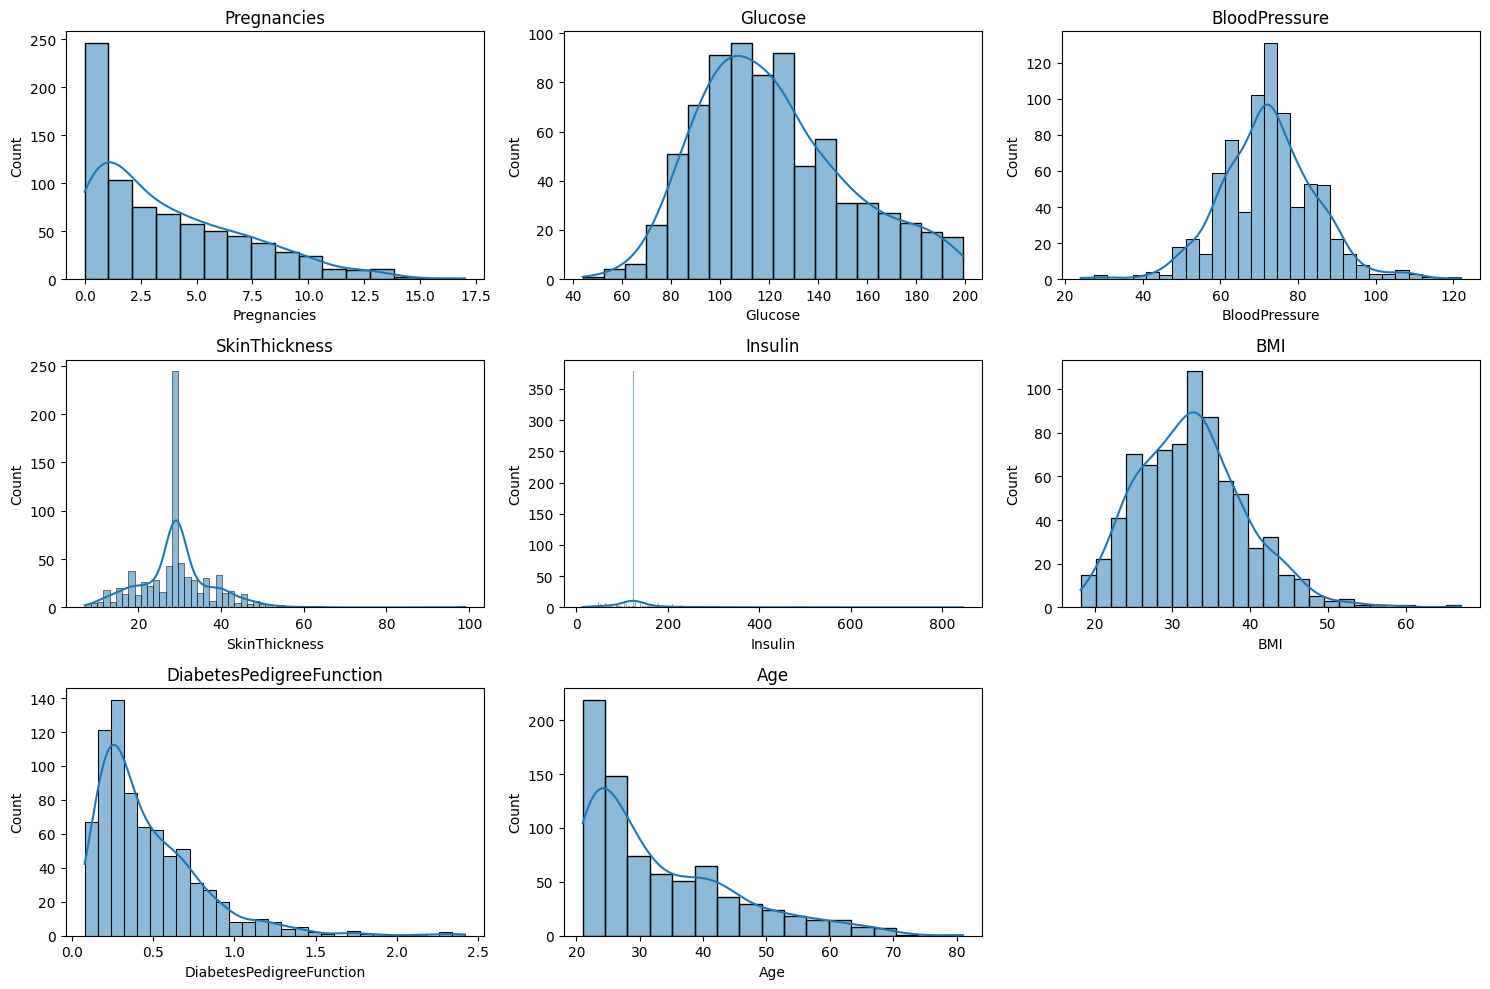

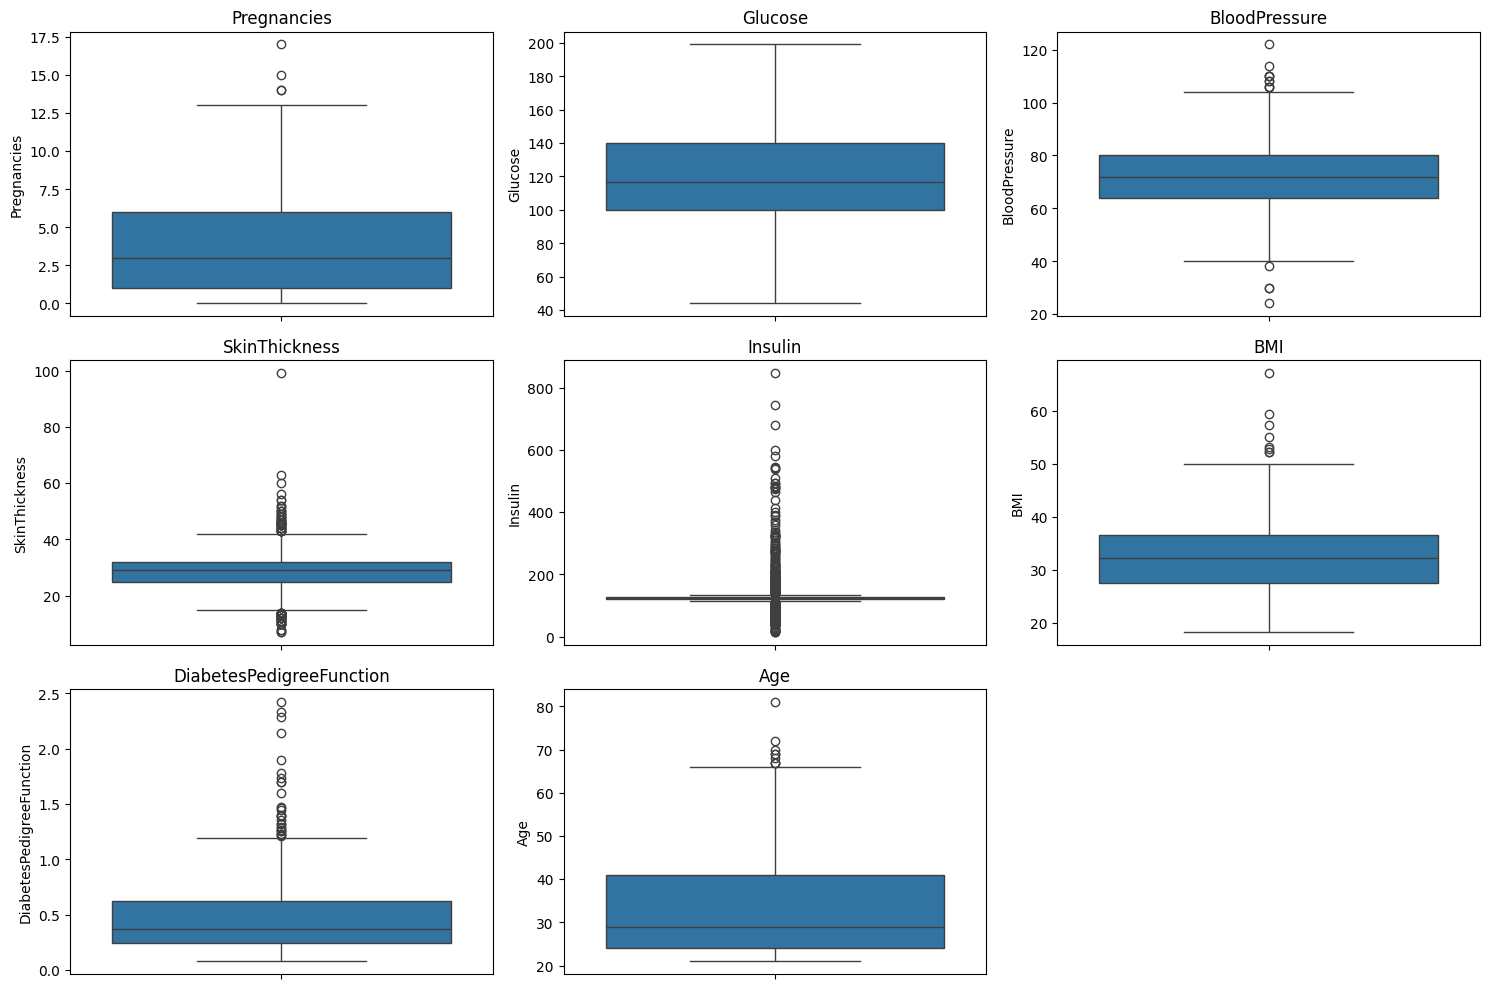

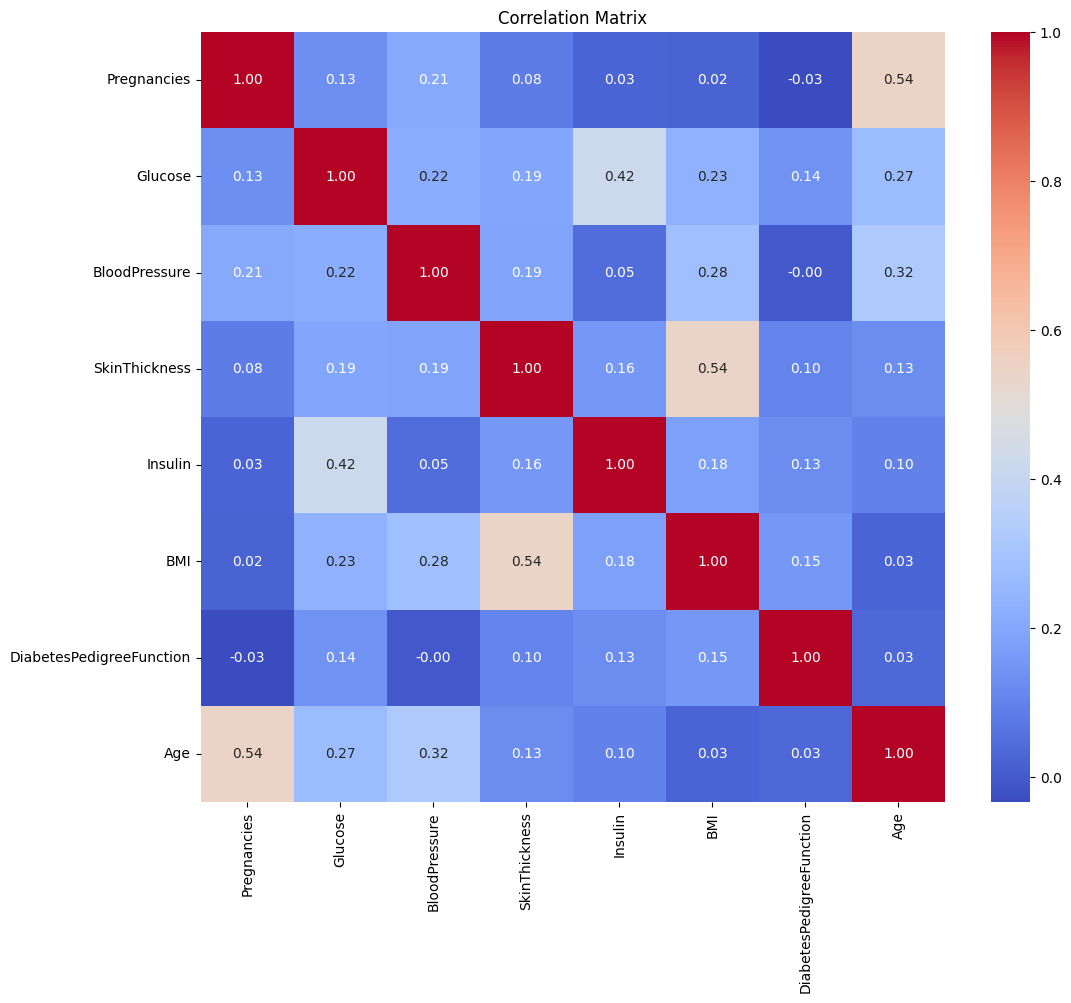

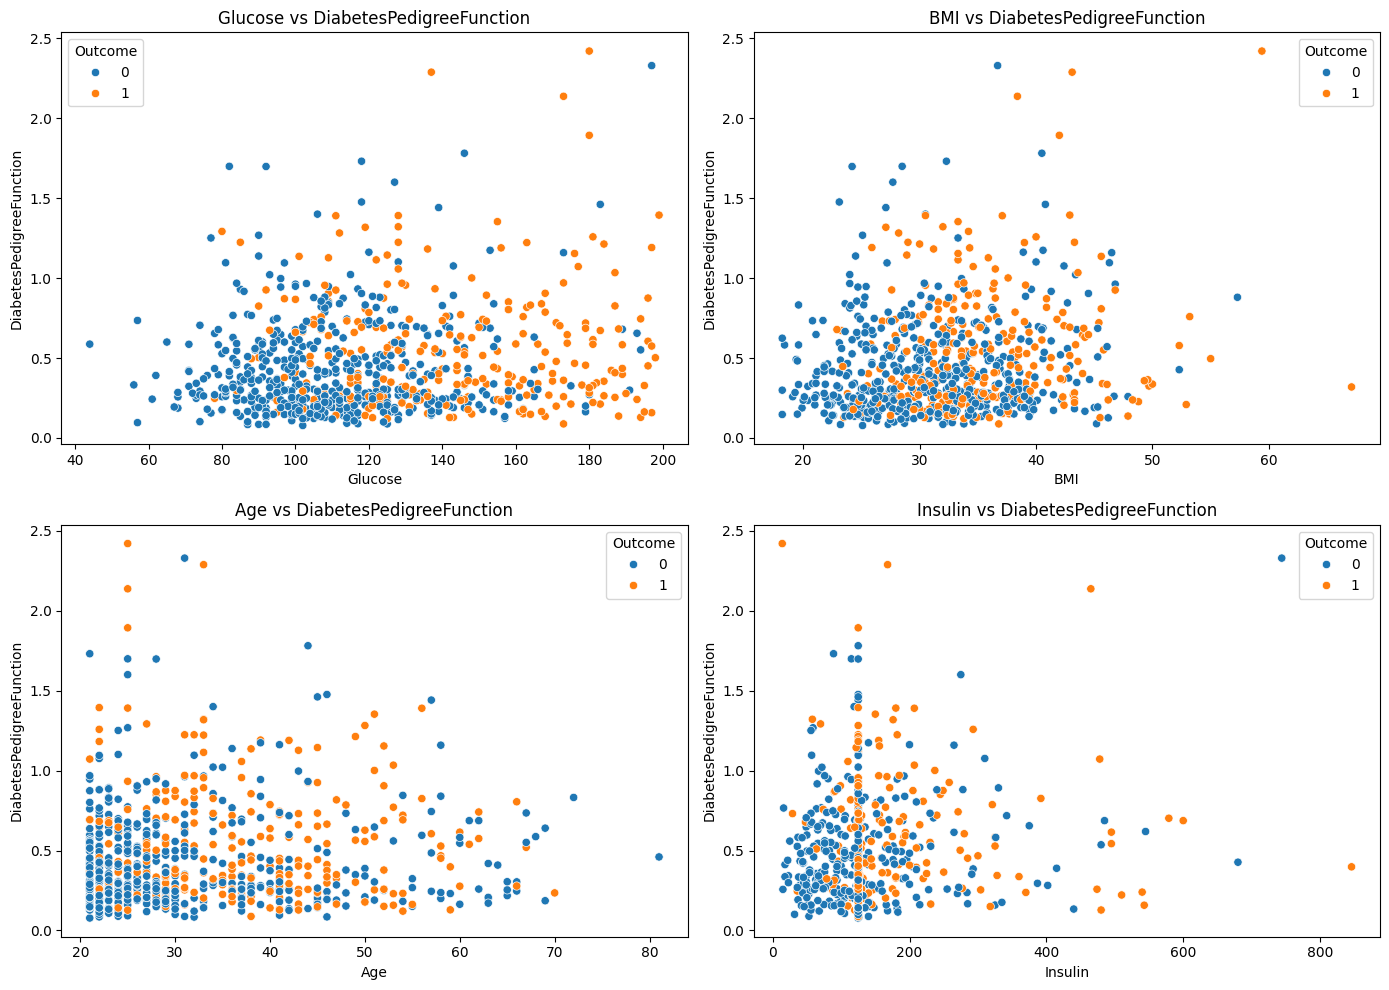


Number of outliers detected by LOF: 77
Percentage of outliers: 10.03%


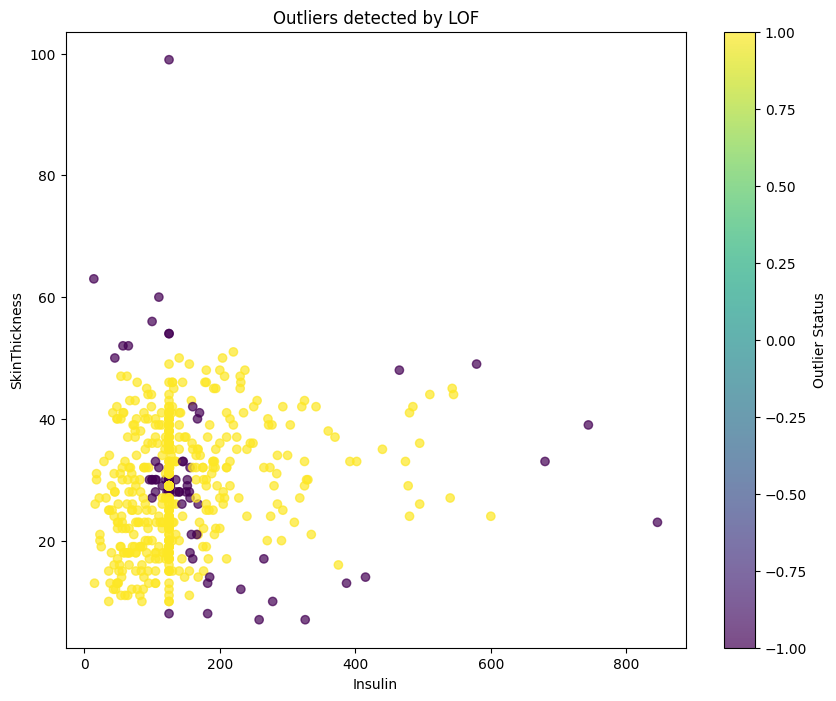


Dataset shape after removing outliers: (691, 16)


In [12]:
### c) EDA and Outlier detection

plt.figure(figsize=(15, 10))
for i, column in enumerate(df_clean.columns[:8]):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_clean[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, column in enumerate(df_clean.columns[:8]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df_clean[column])
    plt.title(column)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
correlation_matrix = df_clean.iloc[:, :8].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(14, 10))
for i, col in enumerate(['Glucose', 'BMI', 'Age', 'Insulin']):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df_clean[col], y=df_clean['DiabetesPedigreeFunction'], hue=df_clean['Outcome'])
    plt.title(f'{col} vs DiabetesPedigreeFunction')
plt.tight_layout()
plt.show()

features_for_lof = ['Insulin', 'SkinThickness']
X_lof = df_clean[features_for_lof].values

scaler = StandardScaler()
X_lof_scaled = scaler.fit_transform(X_lof)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X_lof_scaled)
outlier_scores = lof.negative_outlier_factor_

df_clean['IsOutlier'] = [1 if label == -1 else 0 for label in outlier_labels]
df_clean['OutlierScore'] = outlier_scores

num_outliers = df_clean['IsOutlier'].sum()
print(f"\nNumber of outliers detected by LOF: {num_outliers}")
print(f"Percentage of outliers: {(num_outliers/len(df_clean))*100:.2f}%")

plt.figure(figsize=(10, 8))
plt.scatter(X_lof[:, 0], X_lof[:, 1], c=outlier_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Outlier Status')
plt.xlabel('Insulin')
plt.ylabel('SkinThickness')
plt.title('Outliers detected by LOF')
plt.show()

df_no_outliers = df_clean[df_clean['IsOutlier'] == 0].copy()
print(f"\nDataset shape after removing outliers: {df_no_outliers.shape}")


In [13]:
### d) Predictive analysis: Decision Trees

X_columns = [col for col in df_clean.columns if col not in ['Outcome', 'IsOutlier', 'OutlierScore']]

X_with_outliers = df_clean[X_columns]
y_with_outliers = df_clean['Outcome']

X_no_outliers = df_no_outliers[X_columns]
y_no_outliers = df_no_outliers['Outcome']

baseline_dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

print("\nBaseline Decision Tree Settings:")
print(f"- criterion: {baseline_dt.criterion}")
print(f"- max_depth: {baseline_dt.max_depth}")
print(f"- min_samples_split: {baseline_dt.min_samples_split}")
print(f"- min_samples_leaf: {baseline_dt.min_samples_leaf}")


Baseline Decision Tree Settings:
- criterion: gini
- max_depth: None
- min_samples_split: 2
- min_samples_leaf: 1


In [14]:
### e) Feature Engineering

df_clean['Glucose_Insulin_Ratio'] = df_clean['Glucose'] / (df_clean['Insulin'] + 1)
df_clean['BMI_Age_Product'] = df_clean['BMI'] * df_clean['Age']

X_columns_engineered = X_columns + ['Glucose_Insulin_Ratio', 'BMI_Age_Product']
X_with_outliers_engineered = df_clean[X_columns_engineered]

df_no_outliers['Glucose_Insulin_Ratio'] = df_no_outliers['Glucose'] / (df_no_outliers['Insulin'] + 1)
df_no_outliers['BMI_Age_Product'] = df_no_outliers['BMI'] * df_no_outliers['Age']
X_no_outliers_engineered = df_no_outliers[X_columns_engineered]

print("\nEngineered features (first 5 rows):")
print(X_with_outliers_engineered[['Glucose_Insulin_Ratio', 'BMI_Age_Product']].head())



Engineered features (first 5 rows):
   Glucose_Insulin_Ratio  BMI_Age_Product
0               1.174603           1680.0
1               0.674603            824.6
2               1.452381            745.6
3               0.936842            590.1
4               0.810651           1422.3



Data split sizes:
Training set: 460 samples
Validation set: 154 samples
Test set: 154 samples

Evaluating baseline model with 4-fold cross-validation...

Baseline Model Results:
accuracy: 0.6873
precision: 0.5517
recall: 0.5882
f1: 0.5656
accuracy_std: 0.0237
precision_std: 0.0334
recall_std: 0.0663
f1_std: 0.0269

Model with Outlier Removal Results:
accuracy: 0.7083
precision: 0.5751
recall: 0.6031
f1: 0.5876
accuracy_std: 0.0345
precision_std: 0.0655
recall_std: 0.0168
f1_std: 0.0406

Model with Feature Engineering Results:
accuracy: 0.7019
precision: 0.5707
recall: 0.5861
f1: 0.5774
accuracy_std: 0.0180
precision_std: 0.0097
recall_std: 0.0391
f1_std: 0.0166

Model with Both Outlier Removal and Feature Engineering Results:
accuracy: 0.7029
precision: 0.5667
recall: 0.5912
f1: 0.5774
accuracy_std: 0.0240
precision_std: 0.0668
recall_std: 0.0255
f1_std: 0.0423

Decision Tree with {'criterion': 'gini', 'max_depth': 3}:
F1 Score: 0.5678

Decision Tree with {'criterion': 'gini', 'max_de

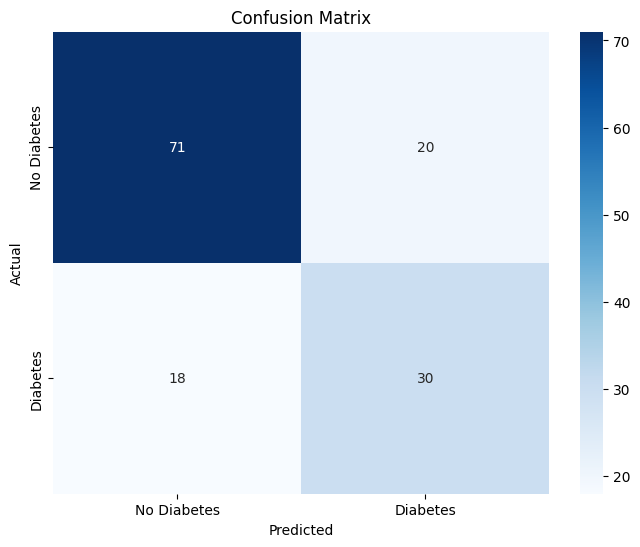


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        91
           1       0.60      0.62      0.61        48

    accuracy                           0.73       139
   macro avg       0.70      0.70      0.70       139
weighted avg       0.73      0.73      0.73       139



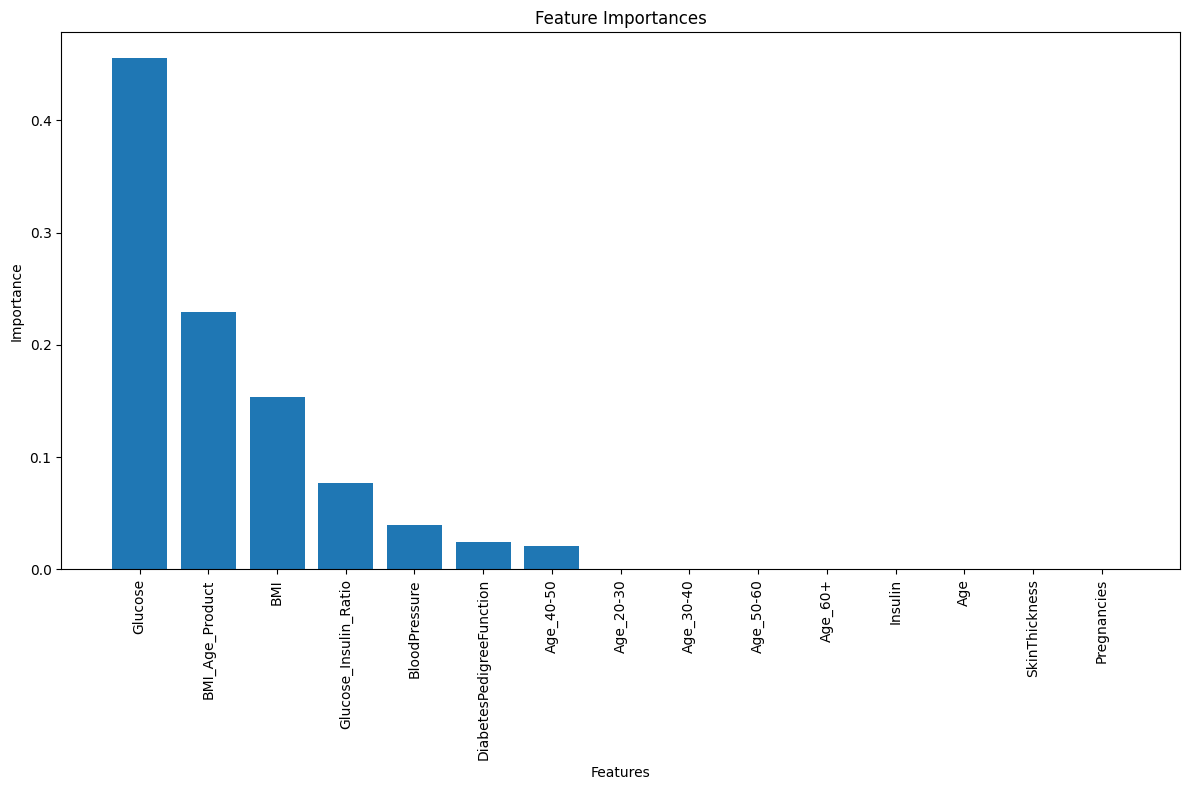

In [19]:
### f) Empirical study

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_with_outliers, y_with_outliers, test_size=0.2, random_state=42, stratify=y_with_outliers
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print("\nData split sizes:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

X_train_val_eng, X_test_eng, y_train_val_eng, y_test_eng = train_test_split(
    X_with_outliers_engineered, y_with_outliers, test_size=0.2, random_state=42, stratify=y_with_outliers
)
X_train_eng, X_val_eng, y_train_eng, y_val_eng = train_test_split(
    X_train_val_eng, y_train_val_eng, test_size=0.25, random_state=42, stratify=y_train_val_eng
)

X_train_val_no_out, X_test_no_out, y_train_val_no_out, y_test_no_out = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42, stratify=y_no_outliers
)
X_train_no_out, X_val_no_out, y_train_no_out, y_val_no_out = train_test_split(
    X_train_val_no_out, y_train_val_no_out, test_size=0.25, random_state=42, stratify=y_train_val_no_out
)

X_train_val_no_out_eng, X_test_no_out_eng, y_train_val_no_out_eng, y_test_no_out_eng = train_test_split(
    X_no_outliers_engineered, y_no_outliers, test_size=0.2, random_state=42, stratify=y_no_outliers
)
X_train_no_out_eng, X_val_no_out_eng, y_train_no_out_eng, y_val_no_out_eng = train_test_split(
    X_train_val_no_out_eng, y_train_val_no_out_eng, test_size=0.25, random_state=42, stratify=y_train_val_no_out_eng
)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

def evaluate_model(model, X, y, fold_strategy=kf):
    accuracy = cross_val_score(model, X, y, cv=fold_strategy, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=fold_strategy, scoring='precision')
    recall = cross_val_score(model, X, y, cv=fold_strategy, scoring='recall')
    f1 = cross_val_score(model, X, y, cv=fold_strategy, scoring='f1')
    
    return {
        'accuracy': accuracy.mean(),
        'precision': precision.mean(),
        'recall': recall.mean(),
        'f1': f1.mean(),
        'accuracy_std': accuracy.std(),
        'precision_std': precision.std(),
        'recall_std': recall.std(),
        'f1_std': f1.std()
    }

print("\nEvaluating baseline model with 4-fold cross-validation...")

baseline_results = evaluate_model(baseline_dt, X_train_val, y_train_val)
print("\nBaseline Model Results:")
for metric, value in baseline_results.items():
    print(f"{metric}: {value:.4f}")

outlier_removal_results = evaluate_model(baseline_dt, X_train_val_no_out, y_train_val_no_out)
print("\nModel with Outlier Removal Results:")
for metric, value in outlier_removal_results.items():
    print(f"{metric}: {value:.4f}")

feature_engineering_results = evaluate_model(baseline_dt, X_train_val_eng, y_train_val_eng)
print("\nModel with Feature Engineering Results:")
for metric, value in feature_engineering_results.items():
    print(f"{metric}: {value:.4f}")

combined_results = evaluate_model(baseline_dt, X_train_val_no_out_eng, y_train_val_no_out_eng)
print("\nModel with Both Outlier Removal and Feature Engineering Results:")
for metric, value in combined_results.items():
    print(f"{metric}: {value:.4f}")

param_combinations = [
    {'criterion': 'gini', 'max_depth': 3},
    {'criterion': 'gini', 'max_depth': 5},
    {'criterion': 'gini', 'max_depth': 10},
    {'criterion': 'entropy', 'max_depth': 3},
    {'criterion': 'entropy', 'max_depth': 5},
    {'criterion': 'entropy', 'max_depth': 10},
]

param_results = {}

for i, params in enumerate(param_combinations):
    dt = DecisionTreeClassifier(random_state=42, **params)
    results = evaluate_model(dt, X_train_val_no_out_eng, y_train_val_no_out_eng)
    param_results[i] = {**params, **results}
    print(f"\nDecision Tree with {params}:")
    print(f"F1 Score: {results['f1']:.4f}")

best_param_idx = max(param_results, key=lambda idx: param_results[idx]['f1'])
best_params = {k: param_results[best_param_idx][k] for k in ['criterion', 'max_depth']}
print(f"\nBest parameters: {best_params} with F1 Score: {param_results[best_param_idx]['f1']:.4f}")

final_model = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    random_state=42
)

final_model.fit(X_train_val_no_out_eng, y_train_val_no_out_eng)

y_pred = final_model.predict(X_test_no_out_eng)

accuracy = accuracy_score(y_test_no_out_eng, y_pred)
precision = precision_score(y_test_no_out_eng, y_pred)
recall = recall_score(y_test_no_out_eng, y_pred)
f1 = f1_score(y_test_no_out_eng, y_pred)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test_no_out_eng, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test_no_out_eng, y_pred)
print("\nClassification Report:")
print(class_report)


feature_importances = final_model.feature_importances_
feature_names = X_train_val_no_out_eng.columns

indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_feature_importances = feature_importances[indices]

plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()



Results Summary Table:
                 Model  Accuracy  Precision    Recall  F1 Score
0             Baseline  0.687314   0.551721  0.588239  0.565591
1      Outlier Removal  0.708333   0.575107  0.603095  0.587646
2  Feature Engineering  0.701925   0.570748  0.586117  0.577412
3             Combined  0.702899   0.566708  0.591168  0.577419


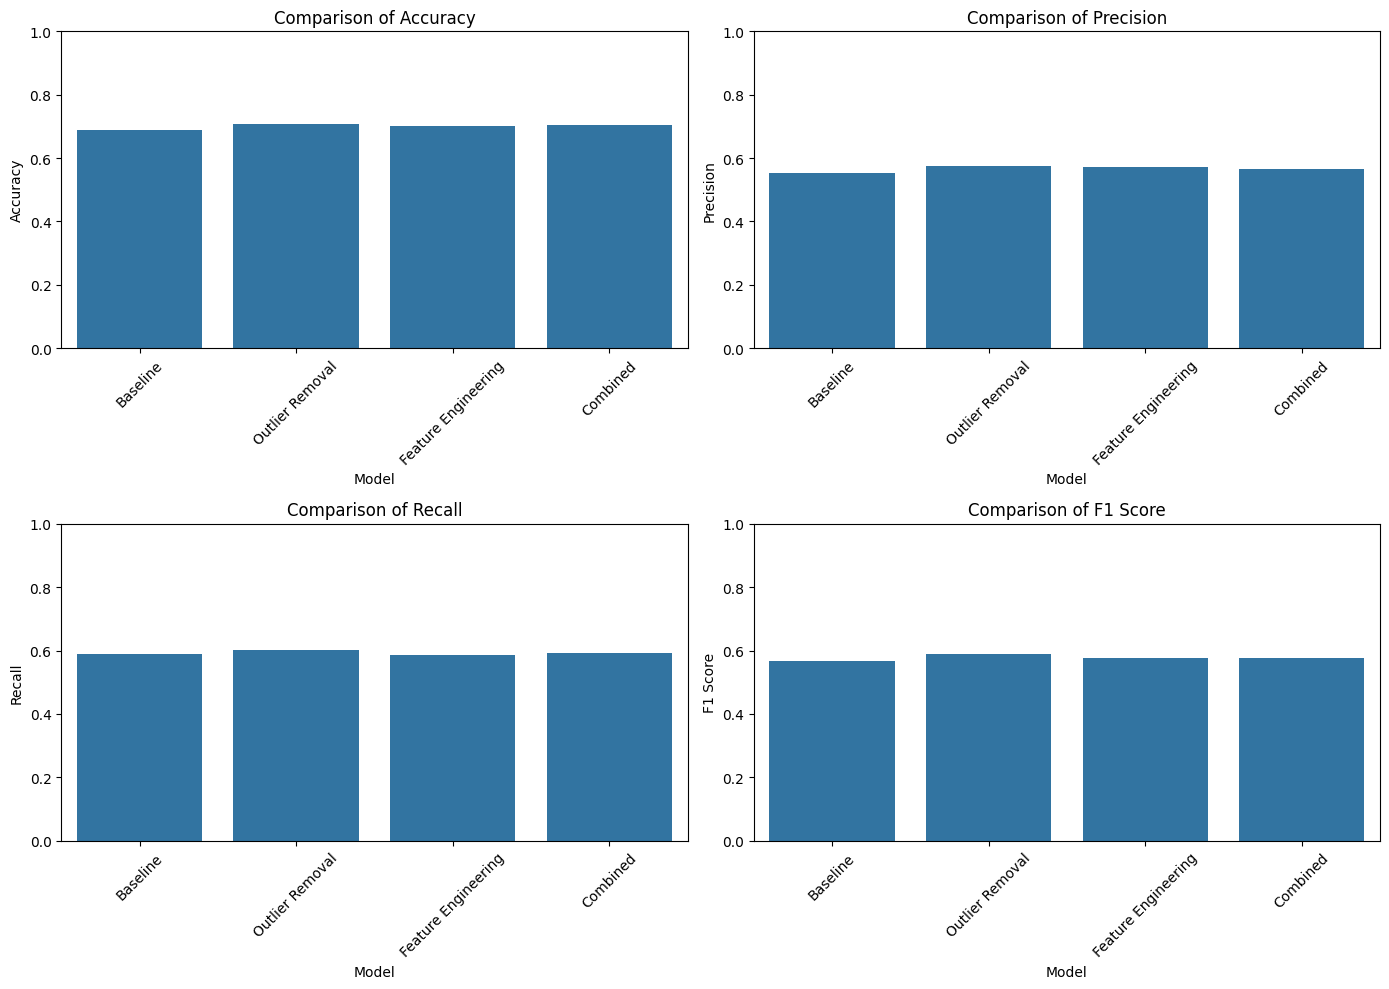


Cross-Validation vs. Test Set Performance:
      Metric  Cross-Validation  Test Set
0   Accuracy          0.702899  0.726619
1  Precision          0.566708  0.600000
2     Recall          0.591168  0.625000
3   F1 Score          0.577419  0.612245


<Figure size 1000x600 with 0 Axes>

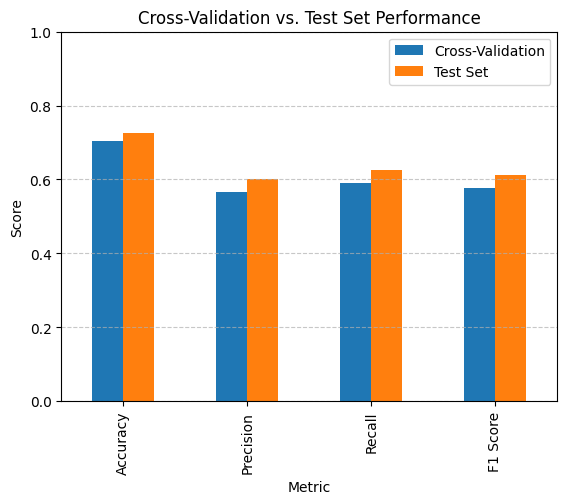


Impact of Outlier Detection:
      Metric  With Outliers  Without Outliers  Improvement
0   Accuracy       0.687314          0.708333     0.021019
1  Precision       0.551721          0.575107     0.023385
2     Recall       0.588239          0.603095     0.014856
3   F1 Score       0.565591          0.587646     0.022055

Impact of Feature Engineering:
      Metric  Without Feature Engineering  With Feature Engineering  \
0   Accuracy                     0.687314                  0.701925   
1  Precision                     0.551721                  0.570748   
2     Recall                     0.588239                  0.586117   
3   F1 Score                     0.565591                  0.577412   

   Improvement  
0     0.014610  
1     0.019027  
2    -0.002122  
3     0.011821  


In [16]:
### g) Result analysis

results_summary = pd.DataFrame({
    'Model': ['Baseline', 'Outlier Removal', 'Feature Engineering', 'Combined'],
    'Accuracy': [baseline_results['accuracy'], outlier_removal_results['accuracy'], 
                feature_engineering_results['accuracy'], combined_results['accuracy']],
    'Precision': [baseline_results['precision'], outlier_removal_results['precision'], 
                 feature_engineering_results['precision'], combined_results['precision']],
    'Recall': [baseline_results['recall'], outlier_removal_results['recall'], 
              feature_engineering_results['recall'], combined_results['recall']],
    'F1 Score': [baseline_results['f1'], outlier_removal_results['f1'], 
                feature_engineering_results['f1'], combined_results['f1']]
})

print("\nResults Summary Table:")
print(results_summary)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=results_summary)
    plt.title(f'Comparison of {metric}')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cv_vs_test = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Cross-Validation': [combined_results['accuracy'], combined_results['precision'], 
                        combined_results['recall'], combined_results['f1']],
    'Test Set': [accuracy, precision, recall, f1]
})

print("\nCross-Validation vs. Test Set Performance:")
print(cv_vs_test)

plt.figure(figsize=(10, 6))
cv_vs_test.set_index('Metric').plot(kind='bar')
plt.title('Cross-Validation vs. Test Set Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

outlier_impact = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'With Outliers': [baseline_results['accuracy'], baseline_results['precision'], 
                     baseline_results['recall'], baseline_results['f1']],
    'Without Outliers': [outlier_removal_results['accuracy'], outlier_removal_results['precision'], 
                        outlier_removal_results['recall'], outlier_removal_results['f1']],
    'Improvement': [outlier_removal_results['accuracy'] - baseline_results['accuracy'],
                   outlier_removal_results['precision'] - baseline_results['precision'],
                   outlier_removal_results['recall'] - baseline_results['recall'],
                   outlier_removal_results['f1'] - baseline_results['f1']]
})

print("\nImpact of Outlier Detection:")
print(outlier_impact)

feature_impact = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Without Feature Engineering': [baseline_results['accuracy'], baseline_results['precision'], 
                                  baseline_results['recall'], baseline_results['f1']],
    'With Feature Engineering': [feature_engineering_results['accuracy'], feature_engineering_results['precision'], 
                               feature_engineering_results['recall'], feature_engineering_results['f1']],
    'Improvement': [feature_engineering_results['accuracy'] - baseline_results['accuracy'],
                   feature_engineering_results['precision'] - baseline_results['precision'],
                   feature_engineering_results['recall'] - baseline_results['recall'],
                   feature_engineering_results['f1'] - baseline_results['f1']]
})

print("\nImpact of Feature Engineering:")
print(feature_impact)


Conclusion:

The results show our diabetes prediction model does a decent job with 73% accuracy, but it's not perfect. Glucose levels clearly matter most, which makes sense medically, while BMI and age are also important factors. Cleaning out the smelly data points and creating smart combinations of features both helped improve our results, especially when we did both together. The model seems reliable since it performed similarly during testing and validation. The confusion matrix shows we're better at identifying healthy patients than diabetic ones, which might be an issue in real-world screening. Overall, it's a solid starting point, but we could potentially do better with more advanced techniques than just a basic decision tree.


References
Data Analysis and Visualization Resources
1. Seaborn Documentation

Link: Seaborn Documentation
How It Helped:
The Seaborn documentation was instrumental in helping us implement various visualizations like countplots, histograms, and scatterplots.
2. Pandas Documentation

Link: Pandas Documentation
How It Helped:
Pandas' powerful data manipulation functions were essential in cleaning and transforming the dataset.
3. OpenAI (ChatGPT), Claude, DeepSeek (R1)

How It Helped:
OpenAI’s ChatGPT, ClaudeAI, and DeepSeek R1 helped by suggesting additional analysis techniques when we were brainstorming how to error-check the datasets. Addtionally, if we dealt with any code error, we used the AI to help us debug.
4. Stack Overflow

Link: Stack Overflow
How It Helped:
Stack Overflow was a key resource to better understand how we can make the required analysis for each error-check.
5. Towards Data Science (Medium)

Link: Towards Data Science
How It Helped:
The article on data exploration techniques from Towards Data Science helped us approach with unknown areas when dealing with error-checking.
